# Energy Consumption Prediction with NGBoost

This Notebook aims to train an NGBoost Model for the same Energy Consumption Prediction Problem [I have attempted in this Notebook with LightGBM](https://www.kaggle.com/hgultekin/predicting-energy-consumption-of-turkey-lightgbm). Before going further into the code, please familiarize yourself with this novel boosting algorithm, which makes probabilistic predictions with Gradient Boosting, through below references. There are these great sources detailing the Natural Gradient Boosting (NGBoost) including [the official research paper](https://arxiv.org/abs/1910.03225) and the [towardsthedatascience article](https://towardsdatascience.com/interpreting-the-probabilistic-predictions-from-ngboost-868d6f3770b2) by one of the authors (Alejandro Schuler), therefore I will not repeat the process here in this notebook:

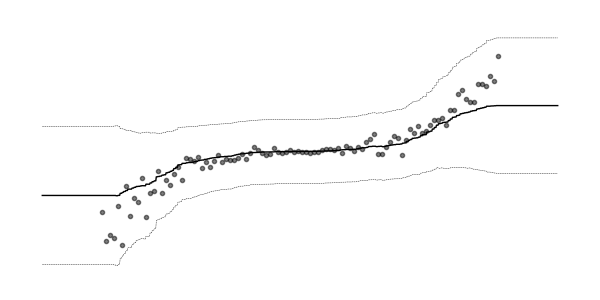


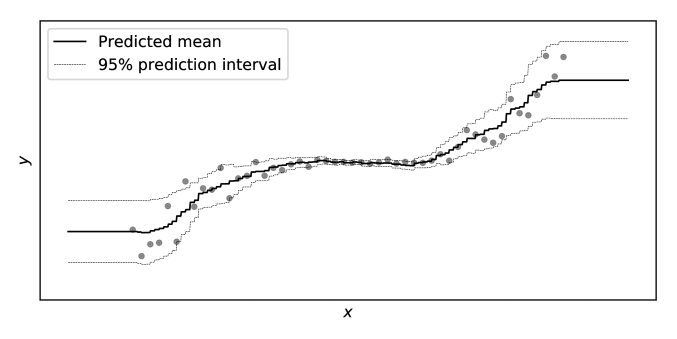

**References**:

* https://stanfordmlgroup.github.io/projects/ngboost/
* https://github.com/stanfordmlgroup/ngboost
* https://arxiv.org/abs/1910.03225
* https://towardsdatascience.com/interpreting-the-probabilistic-predictions-from-ngboost-868d6f3770b2
* https://towardsdatascience.com/ngboost-explained-comparison-to-lightgbm-and-xgboost-fda510903e53


In [1]:
!pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git

  Cloning https://github.com/stanfordmlgroup/ngboost.git to /tmp/pip-req-build-d53c6x_n
  Running command git clone -q https://github.com/stanfordmlgroup/ngboost.git /tmp/pip-req-build-d53c6x_n
     |████████████████████████████████| 343 kB 402 kB/s eta 0:00:01
  Created wheel for ngboost: filename=ngboost-0.2.3.dev0-py3-none-any.whl size=38401 sha256=37f90076331f4f64860f4d420e411a1c61e4d84025092c6b51fb7a0ac228521f
  Stored in directory: /tmp/pip-ephem-wheel-cache-83tyelzw/wheels/9a/7f/a2/ce1d8e2bb0b0efd77e813f2311d132f536343daa6c8b5a81ee
  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47990 sha256=00028ad9aab062f0a0673b70b6fdeae6b033d640ea2665939b15602eaa412e39
  Stored in directory: /root/.cache/pip/wheels/ef/32/31/0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
Successfully built ngboost autograd
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('darkgrid')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hourly-power-consumption-of-turkey-20162020/RealTimeConsumption-31122015-18072020.csv
/kaggle/input/hourly-power-consumption-of-turkey-20162020/RealTimeConsumption-01082011-03082020.csv
/kaggle/input/hourly-power-consumption-of-turkey-20162020/RealTimeConsumption-01012016-04082020.csv
/kaggle/input/predicting-energy-consumption-of-turkey-lightgbm/__results__.html
/kaggle/input/predicting-energy-consumption-of-turkey-lightgbm/__output__.json
/kaggle/input/predicting-energy-consumption-of-turkey-lightgbm/custom.css
/kaggle/input/predicting-energy-consumption-of-turkey-lightgbm/energy_cons_test.csv
/kaggle/input/predicting-energy-consumption-of-turkey-lightgbm/__notebook__.ipynb
/kaggle/input/predicting-energy-consumption-of-turkey-lightgbm/energy_cons_train.csv
/kaggle/input/predicting-energy-consumption-of-turkey-lightgbm/__results___files/__results___20_1.png
/kaggle/input/predicting-energy-consumption-of-turkey-lightgbm/__results___files/__results___49_1.png
/kaggle/inpu

In [3]:
df_train = pd.read_csv('../input/predicting-energy-consumption-of-turkey-lightgbm/energy_cons_train.csv', parse_dates = ['Date'])
df_test = pd.read_csv('../input/predicting-energy-consumption-of-turkey-lightgbm/energy_cons_test.csv', parse_dates = ['Date'])

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34896 entries, 0 to 34895
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                34896 non-null  datetime64[ns]
 1   Consumption (MWh)   34896 non-null  float64       
 2   rolling_mean_t41    34896 non-null  float64       
 3   rolling_mean_t48    34896 non-null  float64       
 4   rolling_mean_t72    34896 non-null  float64       
 5   rolling_mean_t168   34896 non-null  float64       
 6   rolling_mean_t38    34896 non-null  float64       
 7   rolling_mean_t50    34896 non-null  float64       
 8   rolling_mean_t62    34896 non-null  float64       
 9   rolling_median_t38  34896 non-null  float64       
 10  rolling_median_t50  34896 non-null  float64       
 11  rolling_median_t62  34896 non-null  float64       
 12  rolling_std_t38     34896 non-null  float64       
 13  rolling_std_t50     34896 non-null  float64   

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                1776 non-null   datetime64[ns]
 1   Consumption (MWh)   1776 non-null   float64       
 2   rolling_mean_t41    1776 non-null   float64       
 3   rolling_mean_t48    1776 non-null   float64       
 4   rolling_mean_t72    1776 non-null   float64       
 5   rolling_mean_t168   1776 non-null   float64       
 6   rolling_mean_t38    1776 non-null   float64       
 7   rolling_mean_t50    1776 non-null   float64       
 8   rolling_mean_t62    1776 non-null   float64       
 9   rolling_median_t38  1776 non-null   float64       
 10  rolling_median_t50  1776 non-null   float64       
 11  rolling_median_t62  1776 non-null   float64       
 12  rolling_std_t38     1776 non-null   float64       
 13  rolling_std_t50     1776 non-null   float64     

In [6]:
df_train.head()

,Date,Consumption (MWh),rolling_mean_t41,rolling_mean_t48,rolling_mean_t72,rolling_mean_t168,rolling_mean_t38,rolling_mean_t50,rolling_mean_t62,rolling_median_t38,...,rolling_std_t50,rolling_std_t62,hourofday,quarter,month,year,dayofyear,dayofmonth,weekofyear,days_in_month
0,2016-01-08 00:00:00,10.261268,10.258853,10.281591,10.283477,10.176496,10.286262,10.397811,10.405176,10.242484,...,0.151209,0.155102,0,1,1,2016,8,8,1,31
1,2016-01-08 01:00:00,10.207782,10.410436,10.226115,10.226955,10.126344,10.301210,10.396919,10.404201,10.242484,...,0.150254,0.154070,1,1,1,2016,8,8,1,31
2,2016-01-08 02:00:00,10.164941,10.498421,10.187913,10.178722,10.066185,10.319135,10.395417,10.402959,10.242484,...,0.149013,0.153056,2,1,1,2016,8,8,1,31
3,2016-01-08 03:00:00,10.139214,10.524438,10.155032,10.160887,10.019749,10.342480,10.393985,10.401455,10.334645,...,0.147716,0.151642,3,1,1,2016,8,8,1,31
4,2016-01-08 04:00:00,10.131784,10.541274,10.160670,10.164931,9.998975,10.369701,10.392607,10.399921,10.453558,...,0.146369,0.150078,4,1,1,2016,8,8,1,31


In [7]:
df_train[['Consumption (MWh)']].describe()

,Consumption (MWh)
count,34896.000000
mean,10.384395
std,0.162760
min,0.000000
25%,10.268843
50%,10.402990
75%,10.496041
max,10.759251


In [8]:
df_train[df_train['Consumption (MWh)'] == 0] # I received an overflow error while training the model, I suspected some zeros may be the reason, yes found it!

,Date,Consumption (MWh),rolling_mean_t41,rolling_mean_t48,rolling_mean_t72,rolling_mean_t168,rolling_mean_t38,rolling_mean_t50,rolling_mean_t62,rolling_median_t38,...,rolling_std_t50,rolling_std_t62,hourofday,quarter,month,year,dayofyear,dayofmonth,weekofyear,days_in_month
1898,2016-03-27 02:00:00,0.0,10.428284,10.147433,10.154879,10.108362,10.259428,10.314952,10.314442,10.197387,...,0.116139,0.113131,2,1,3,2016,87,27,12,31


In [9]:
#df_train = df_train.loc['2016-03-28':, :].reset_index()

In [10]:
df_test[['Consumption (MWh)']].describe()

,Consumption (MWh)
count,1776.000000
mean,10.439672
std,0.134469
min,10.066309
25%,10.317875
50%,10.463477
75%,10.554774
max,10.681068


In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_train.Date, y=np.expm1(df_train['Consumption (MWh)']),
                    mode='markers',
                    name='TRAIN SET'))
fig.add_trace(go.Scatter(x=df_test.Date, y=np.expm1(df_test['Consumption (MWh)']),
                    mode='markers',
                    name='TEST SET'))
fig.show()

In [12]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [13]:
print(df_train.shape, df_test.shape) 

(34896, 23) (1776, 23)


In [14]:
y_train = df_train['Consumption (MWh)'].values
X_train = df_train.drop(['Date','Consumption (MWh)'], axis=1).values

y_test = df_test['Consumption (MWh)'].values
X_test = df_test.drop(['Date','Consumption (MWh)'], axis=1).values

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

In [16]:
model_ngb = NGBRegressor(n_estimators=650,  natural_gradient=True, learning_rate = 0.01,Base=default_tree_learner, Dist=Normal, Score=MLE, verbose_eval =50)
model_ngb.fit(X_train, y_train, X_val = X_test, Y_val = y_test, early_stopping_rounds = 10)

/opt/conda/lib/python3.7/site-packages/ngboost/distns/normal.py:67: RuntimeWarning:

overflow encountered in exp

/opt/conda/lib/python3.7/site-packages/ngboost/distns/normal.py:68: RuntimeWarning:

overflow encountered in square



[iter 0] loss=-0.3966 val_loss=-0.4998 scale=0.2500 norm=0.1270
[iter 50] loss=-0.7547 val_loss=-0.8020 scale=2.0000 norm=0.7878
[iter 100] loss=-1.0815 val_loss=-1.1665 scale=2.0000 norm=0.8685
[iter 150] loss=-1.3251 val_loss=-1.4367 scale=2.0000 norm=0.9110
[iter 200] loss=-1.4906 val_loss=-1.6213 scale=2.0000 norm=0.9287
[iter 250] loss=-1.5838 val_loss=-1.7141 scale=2.0000 norm=0.9427
[iter 300] loss=-1.6428 val_loss=-1.7567 scale=2.0000 norm=0.9568
[iter 350] loss=-1.6825 val_loss=-1.7909 scale=1.0000 norm=0.4821
[iter 400] loss=-1.7123 val_loss=-1.8167 scale=1.0000 norm=0.4828
[iter 450] loss=-1.7360 val_loss=-1.8374 scale=1.0000 norm=0.4837
[iter 500] loss=-1.7581 val_loss=-1.8532 scale=1.0000 norm=0.4825
[iter 550] loss=-1.7749 val_loss=-1.8668 scale=1.0000 norm=0.4821
[iter 600] loss=-1.7886 val_loss=-1.8781 scale=1.0000 norm=0.4828


NGBRegressor(n_estimators=650,
             random_state=RandomState(MT19937) at 0x7FE71C0C58D0,
             verbose_eval=50)

In [17]:
y_train_ngb = model_ngb.pred_dist(X_train)
print("Train set RMSE (Log): " + str(np.sqrt(mean_squared_error(y_train_ngb.loc, y_train))))
print("Train set MAPE (Log): " + str(mean_absolute_percentage_error(y_train, y_train_ngb.loc)))
print("Train set RMSE (Non-Log): " + str(np.sqrt(mean_squared_error(np.expm1(y_train_ngb.loc), np.expm1(y_train)))))
print("Train set MAPE (Non-Log): " + str(mean_absolute_percentage_error(np.expm1(y_train), np.expm1(y_train_ngb.loc))))

Train set RMSE (Log): 0.0688230186472653
Train set MAPE (Log): 0.35993028386544806
Train set RMSE (Non-Log): 1878.1904632244916
Train set MAPE (Non-Log): 3.76665512491609


In [18]:
y_test_ngb= model_ngb.pred_dist(X_test)
print("Validation set RMSE (Log): " + str(np.sqrt(mean_squared_error(y_test_ngb.loc, y_test))))
print("Validation set MAPE (Log): " + str(mean_absolute_percentage_error(y_test, y_test_ngb.loc)))
print("Validation set RMSE (Non-Log): " + str(np.sqrt(mean_squared_error(np.expm1(y_test_ngb.loc), np.expm1(y_test)))))
print("Validation set MAPE (Non-Log): " + str(mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_test_ngb.loc))))

Validation set RMSE (Log): 0.04499813149271889
Validation set MAPE (Log): 0.30307670286825594
Validation set RMSE (Non-Log): 1569.4494070346846
Validation set MAPE (Non-Log): 3.1720938356681034


In [19]:
predictions = pd.DataFrame(y_test_ngb.loc, columns=['Predictions'])
predictions_upper = pd.DataFrame(y_test_ngb.dist.interval(0.95)[1], columns=['Predictions_upper'])
predictions_lower = pd.DataFrame(y_test_ngb.dist.interval(0.95)[0], columns=['Predictions_lower'])

In [20]:
df_figure = pd.concat([df_test[['Date', 'Consumption (MWh)']], predictions, predictions_lower, predictions_upper], axis=1)
df_figure

,Date,Consumption (MWh),Predictions,Predictions_lower,Predictions_upper
0,2020-01-01 00:00:00,10.244466,10.233115,10.104831,10.361398
1,2020-01-01 01:00:00,10.186763,10.181002,10.063283,10.298721
2,2020-01-01 02:00:00,10.138124,10.156734,10.037564,10.275904
3,2020-01-01 03:00:00,10.098747,10.139955,10.023713,10.256196
4,2020-01-01 04:00:00,10.074558,10.112350,9.992832,10.231868
...,...,...,...,...,...
1771,2020-03-14 19:00:00,10.494452,10.487225,10.413275,10.561176
1772,2020-03-14 20:00:00,10.483987,10.474108,10.402218,10.545998
1773,2020-03-14 21:00:00,10.454384,10.453520,10.380007,10.527033
1774,2020-03-14 22:00:00,10.416152,10.407785,10.338877,10.476694


In [21]:
df_figure.isna().sum()

Date                 0
Consumption (MWh)    0
Predictions          0
Predictions_lower    0
Predictions_upper    0
dtype: int64

In [22]:
df_figure[['Consumption (MWh)','Predictions', 'Predictions_lower', 'Predictions_upper']] = np.expm1(df_figure[['Consumption (MWh)','Predictions', 'Predictions_lower', 'Predictions_upper']])

In [23]:
df_figure

,Date,Consumption (MWh),Predictions,Predictions_lower,Predictions_upper
0,2020-01-01 00:00:00,28125.46,27807.992574,24459.903315,31614.351978
1,2020-01-01 01:00:00,26548.41,26395.904351,23464.406914,29693.629284
2,2020-01-01 02:00:00,25287.99,25763.007699,22868.599637,29023.736036
3,2020-01-01 03:00:00,24311.53,25334.324551,22554.029477,28457.338783
4,2020-01-01 04:00:00,23730.48,24644.509985,21868.142204,27773.347834
...,...,...,...,...,...
1771,2020-03-14 19:00:00,36113.59,35853.538878,33297.739324,38605.505358
1772,2020-03-14 20:00:00,35737.63,35386.284879,32931.576605,38023.960698
1773,2020-03-14 21:00:00,34695.16,34665.194081,32208.199695,37309.613845
1774,2020-03-14 22:00:00,33393.67,33115.452742,30910.298940,35477.918060


In [24]:
def plot_results(df, title):
    fig, ax = plt.subplots(figsize=(22, 5))
    plt.plot(df.Date, df.Predictions, label = 'Consumption_Predicted', color='b', lw=2)
    plt.fill_between(df.Date, df.Predictions_lower,  df.Predictions_upper,label = '95% Prediction Interval', color='gray', alpha=0.5)
    plt.scatter(df.Date, df['Consumption (MWh)'], label = 'Consumption (MWh) Actual', color='g', lw=3)
    ax.legend(fontsize = 14)
    plt.title('Hourly Power Consumption Actual vs. Predicted Values with Prediction Intervals')
    plt.xlabel(title)
    plt.show()

## First Week Predictions:

In [25]:
print(df_test.Date.min(), df_test.Date.max())

2020-01-01 00:00:00 2020-03-14 23:00:00


In [26]:
df_figure_fw = df_figure.set_index('Date').loc['2020-01-01 00:00:00':'2020-01-08 00:00:00', :].reset_index()
df_figure_fw

,Date,Consumption (MWh),Predictions,Predictions_lower,Predictions_upper
0,2020-01-01 00:00:00,28125.46,27807.992574,24459.903315,31614.351978
1,2020-01-01 01:00:00,26548.41,26395.904351,23464.406914,29693.629284
2,2020-01-01 02:00:00,25287.99,25763.007699,22868.599637,29023.736036
3,2020-01-01 03:00:00,24311.53,25334.324551,22554.029477,28457.338783
4,2020-01-01 04:00:00,23730.48,24644.509985,21868.142204,27773.347834
...,...,...,...,...,...
164,2020-01-07 20:00:00,39558.75,36433.588790,33218.178939,39960.230309
165,2020-01-07 21:00:00,38610.42,34940.564621,31405.381809,38873.676668
166,2020-01-07 22:00:00,37513.61,33143.682531,29082.880942,37771.468614
167,2020-01-07 23:00:00,35597.18,32605.916203,28842.495091,36860.378308


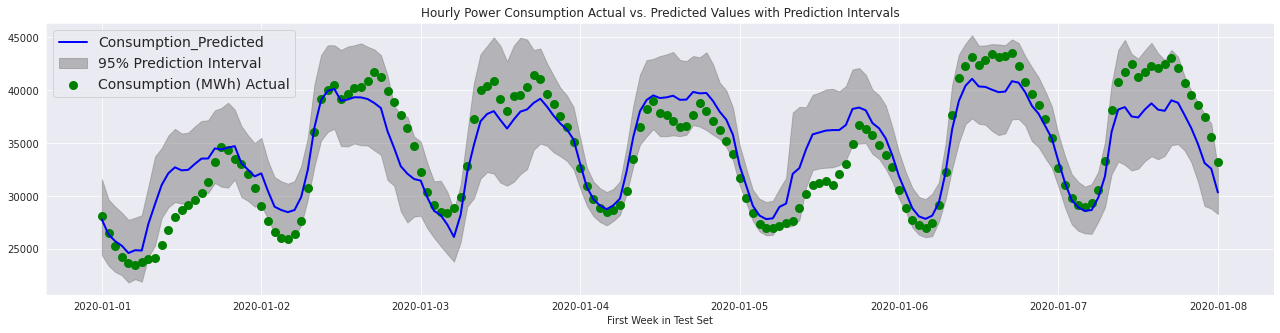

In [27]:
plot_results(df_figure_fw, 'First Week in Test Set')

## First Month Predictions:

In [28]:
df_figure_fm = df_figure.set_index('Date').loc['2020-01-01 00:00:00':'2020-02-15 00:00:00', :].reset_index()
df_figure_fm

,Date,Consumption (MWh),Predictions,Predictions_lower,Predictions_upper
0,2020-01-01 00:00:00,28125.46,27807.992574,24459.903315,31614.351978
1,2020-01-01 01:00:00,26548.41,26395.904351,23464.406914,29693.629284
2,2020-01-01 02:00:00,25287.99,25763.007699,22868.599637,29023.736036
3,2020-01-01 03:00:00,24311.53,25334.324551,22554.029477,28457.338783
4,2020-01-01 04:00:00,23730.48,24644.509985,21868.142204,27773.347834
...,...,...,...,...,...
1076,2020-02-14 20:00:00,39455.47,39010.760543,36551.805745,41635.132429
1077,2020-02-14 21:00:00,38411.91,38551.584645,36230.088553,41021.829900
1078,2020-02-14 22:00:00,37198.14,37196.043748,34634.597634,39946.919426
1079,2020-02-14 23:00:00,35846.53,35631.682430,33198.427592,38243.275556


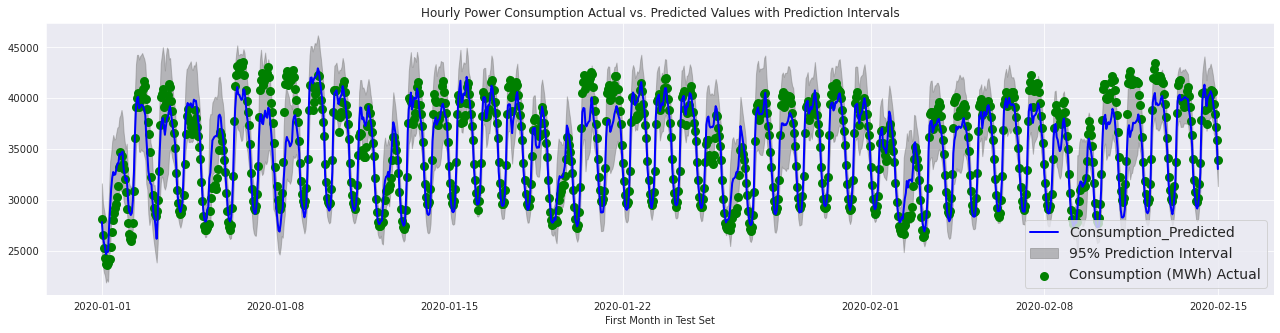

In [29]:
plot_results(df_figure_fm, 'First Month in Test Set')

## Last Month Predictions

In [30]:
df_figure_lm = df_figure.set_index('Date').loc['2020-02-15 00:00:00':'2020-03-14 23:00:00', :].reset_index()
df_figure_lm

,Date,Consumption (MWh),Predictions,Predictions_lower,Predictions_upper
0,2020-02-15 00:00:00,33880.68,33026.140503,31344.470090,34798.031781
1,2020-02-15 01:00:00,32068.55,31598.802368,30064.379160,33211.536731
2,2020-02-15 02:00:00,30571.19,30413.657062,29078.582369,31810.026461
3,2020-02-15 03:00:00,29705.52,29666.522164,28364.243530,31028.589801
4,2020-02-15 04:00:00,29397.75,29244.806109,27961.039025,30587.512312
...,...,...,...,...,...
691,2020-03-14 19:00:00,36113.59,35853.538878,33297.739324,38605.505358
692,2020-03-14 20:00:00,35737.63,35386.284879,32931.576605,38023.960698
693,2020-03-14 21:00:00,34695.16,34665.194081,32208.199695,37309.613845
694,2020-03-14 22:00:00,33393.67,33115.452742,30910.298940,35477.918060


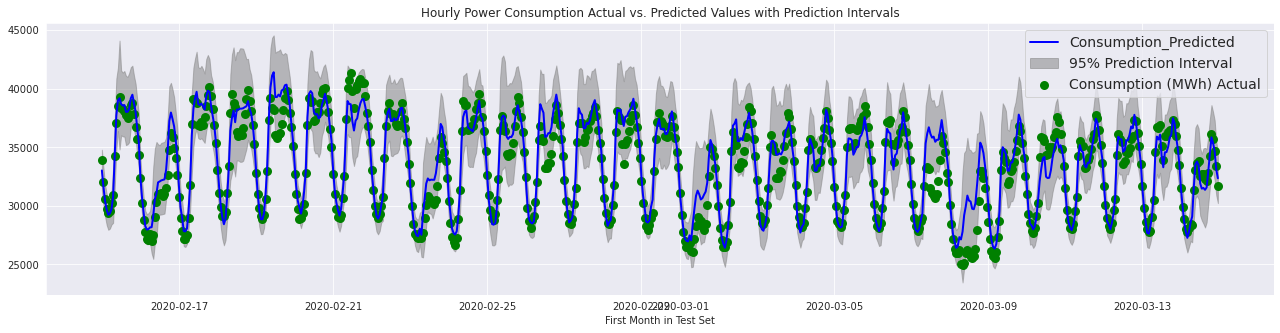

In [31]:
plot_results(df_figure_lm, 'First Month in Test Set')

## Or with my favorite visualization tool :)

In [32]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_figure.Date, y=df_figure.Predictions,
    fill=None,
    mode='lines',
    line_color='blue',
    name='Predictions'
    ))
fig.add_trace(go.Scatter(x=df_figure.Date, y=df_figure.Predictions_lower,
    fill=None,
    mode='lines',
    line_color='gray',
    name='Predictions_Lower',
    ))
fig.add_trace(go.Scatter(
    x=df_figure.Date, y=df_figure.Predictions_upper,
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='gray',name='Predictions_Upper'
    ))
fig.add_trace(go.Scatter(x=df_figure.Date, y=df_figure['Consumption (MWh)'],
    fill=None,
    mode='markers',
    line_color='green',
    name='Actual Consumption'
    ))

fig.show()

**Final Thoughts**: NGboost seems to give more accurate results for this particular problem w.r.t. the LightGBM, along with an additional flexibility of easily generating the prediction intervals along with the predictions. Based on my multiple observations of comparing the two boosting algorithms, I can say that the fact that the LightGBM faster and NGboost is slightly more accurate (for similar hyperparameters) usually holds true.